In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
import re
import sys
import os

In [2]:
df_trips=pd.read_parquet(r"..\..\dados\trips_historico.parquet")
df_stops=pd.read_parquet(r"..\..\dados\stops_historico_categorizado.parquet")
df_passageiros=pd.read_parquet(r"..\..\dados\passageiros_unificado.parquet")

In [3]:
df_trips=df_trips.merge(df_stops,on=['data_referencia', 'stop_id', 'stop_name','stop_desc', 'stop_lat', 'stop_lon'])

# Qtd de paradas e rotas ao longo do tempo

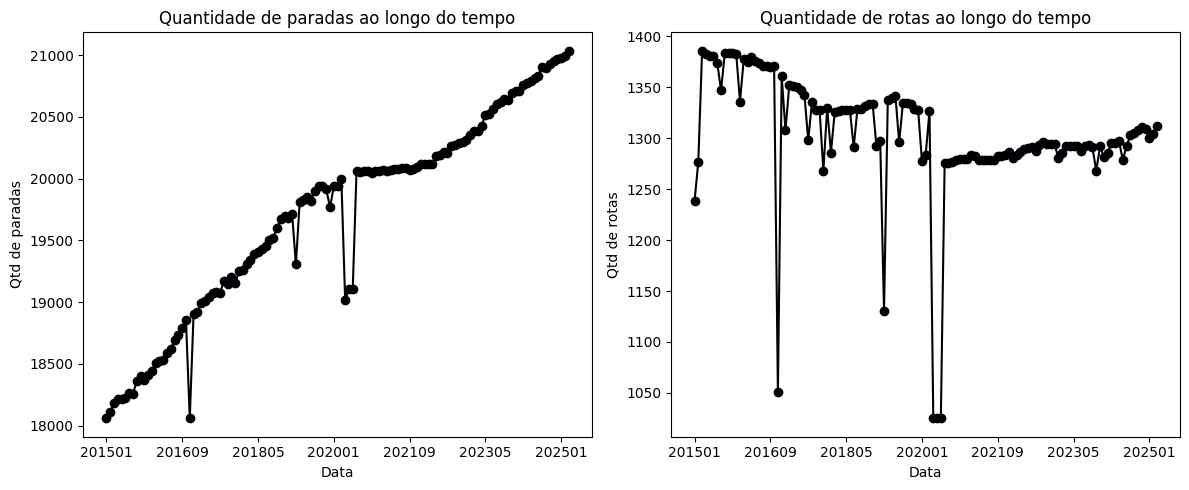

In [19]:
qtd_paradas_historico=df_trips.drop_duplicates(subset=['data_referencia','stop_id']).groupby("data_referencia").count()['stop_id']
qtd_rotas_historico=df_trips.drop_duplicates(subset=['data_referencia','route_id']).groupby("data_referencia").count()['route_id']
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

qtd_paradas_historico.plot(
    figsize=(12, 5), marker="o", ax=axes[0],colormap='magma')
axes[0].set_title("Quantidade de paradas ao longo do tempo")
axes[0].set_ylabel("Qtd de paradas")
axes[0].set_xlabel("Data")
plt.tight_layout()

qtd_rotas_historico.plot(
    figsize=(12, 5), marker="o", ax=axes[1],colormap='magma')
axes[1].set_title("Quantidade de rotas ao longo do tempo")
plt.ylabel("Qtd de rotas")
plt.xlabel("Data")

plt.tight_layout()
plt.show()

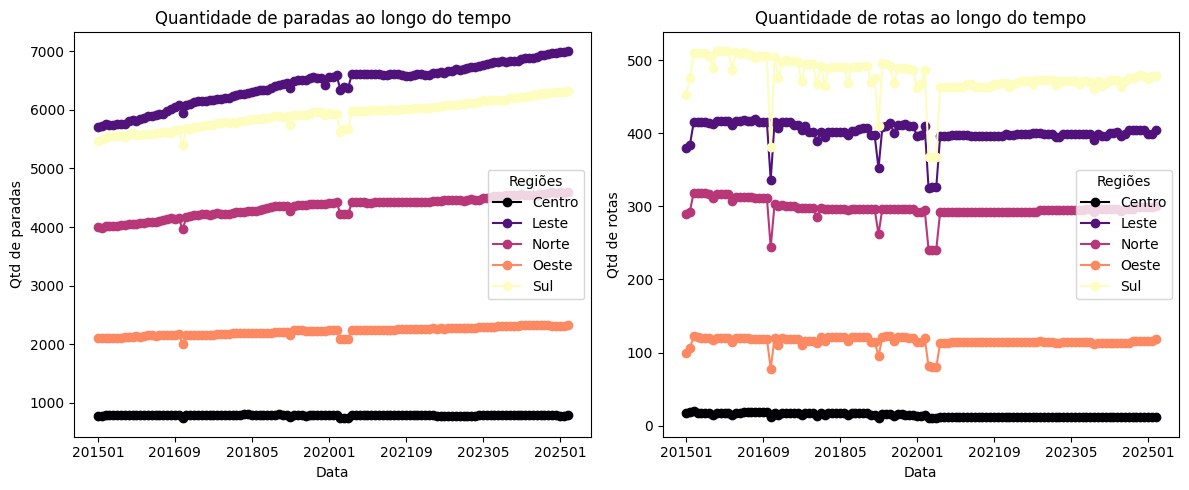

In [20]:
qtd_paradas_por_zona_historico=df_trips.drop_duplicates(subset=['data_referencia','stop_id']).fillna("Nenhuma").groupby(["data_referencia",'Regiões']).count()['stop_id'].unstack()
qtd_rotas_por_zona_historico=df_trips.drop_duplicates(subset=['data_referencia','route_id']).fillna("Nenhuma").groupby(["data_referencia",'Regiões']).count()['route_id'].unstack()

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

qtd_paradas_por_zona_historico.plot(
    figsize=(12, 5), marker="o", ax=axes[0],colormap='magma')
axes[0].set_title("Quantidade de paradas ao longo do tempo")
axes[0].set_ylabel("Qtd de paradas")
axes[0].set_xlabel("Data")

# plt.show()

qtd_rotas_por_zona_historico.plot(
    figsize=(12, 5), marker="o", ax=axes[1],colormap='magma')
axes[1].set_title("Quantidade de rotas ao longo do tempo")
axes[1].set_ylabel("Qtd de rotas")
axes[1].set_xlabel("Data")

plt.tight_layout()
plt.show()

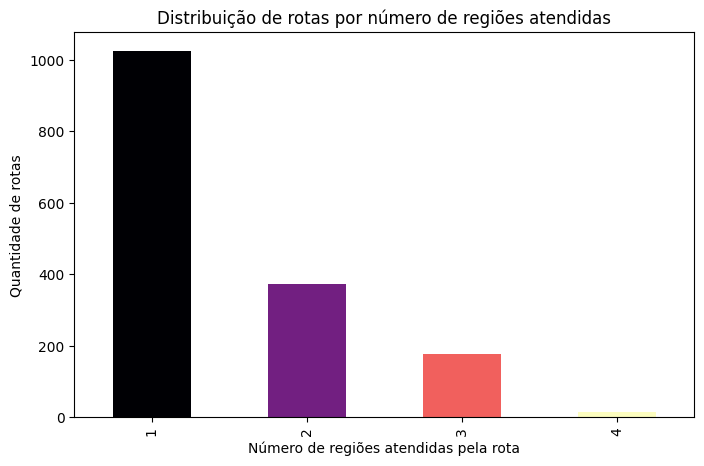

In [26]:
import numpy as np
# agrupar as regiões que cada rota percorre
rotas_regioes = df_trips.groupby('route_id')['Regiões'].unique()

# criar um DataFrame com o número de regiões por rota
df_rotas_regioes = rotas_regioes.apply(lambda x: len(x)).reset_index(name='qtd_regioes')

df_rotas_regioes['qtd_regioes'].value_counts().sort_index().plot(
    kind='bar',
    figsize=(8,5),
    color=plt.cm.magma(np.linspace(0,1,df_rotas_regioes['qtd_regioes'].nunique()))
)
plt.xlabel('Número de regiões atendidas pela rota')
plt.ylabel('Quantidade de rotas')
plt.title('Distribuição de rotas por número de regiões atendidas')
plt.show()

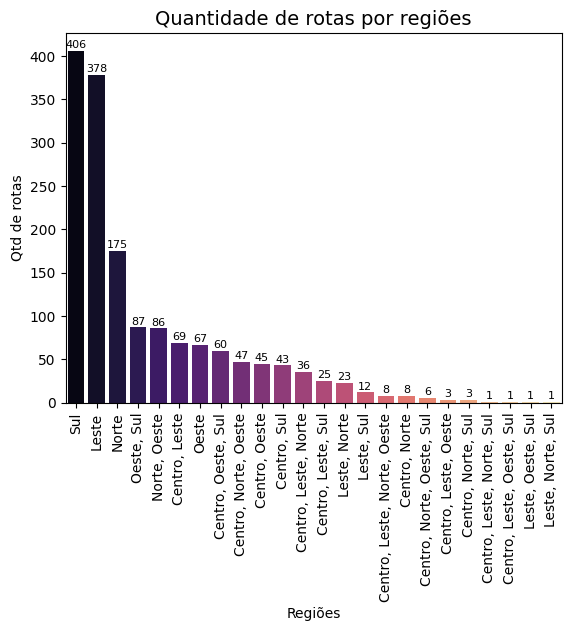

In [55]:
rotas_regioes = (
    df_trips.groupby('route_id')['Regiões']
    .unique()
    .apply(sorted)  # garante ordem consistente
)

df_combinacoes = (
    rotas_regioes
    .apply(lambda x: ', '.join(x))  # transforma ['Sul','Leste'] → "Leste, Sul"
    .reset_index(name='combinacao')
)

freq_combinacoes = (
    df_combinacoes['combinacao']
    .value_counts()
    .reset_index()
    .rename(columns={'count': 'Qtd de rotas', 'combinacao': 'Regiões'})
)

ax = sns.barplot(x=freq_combinacoes['Regiões'], y=freq_combinacoes['Qtd de rotas'], palette="magma")
# Adiciona rótulo de dados em cada barra
for i, v in enumerate(freq_combinacoes['Qtd de rotas']):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=8)

plt.title('Quantidade de rotas por regiões', fontsize=14)
plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()

In [45]:
freq_combinacoes

,Regiões,Qtd de rotas
0,Sul,406
1,Leste,378
2,Norte,175
3,"Oeste, Sul",87
4,"Norte, Oeste",86
5,"Centro, Leste",69
6,Oeste,67
7,"Centro, Oeste, Sul",60
8,"Centro, Norte, Oeste",47
9,"Centro, Oeste",45


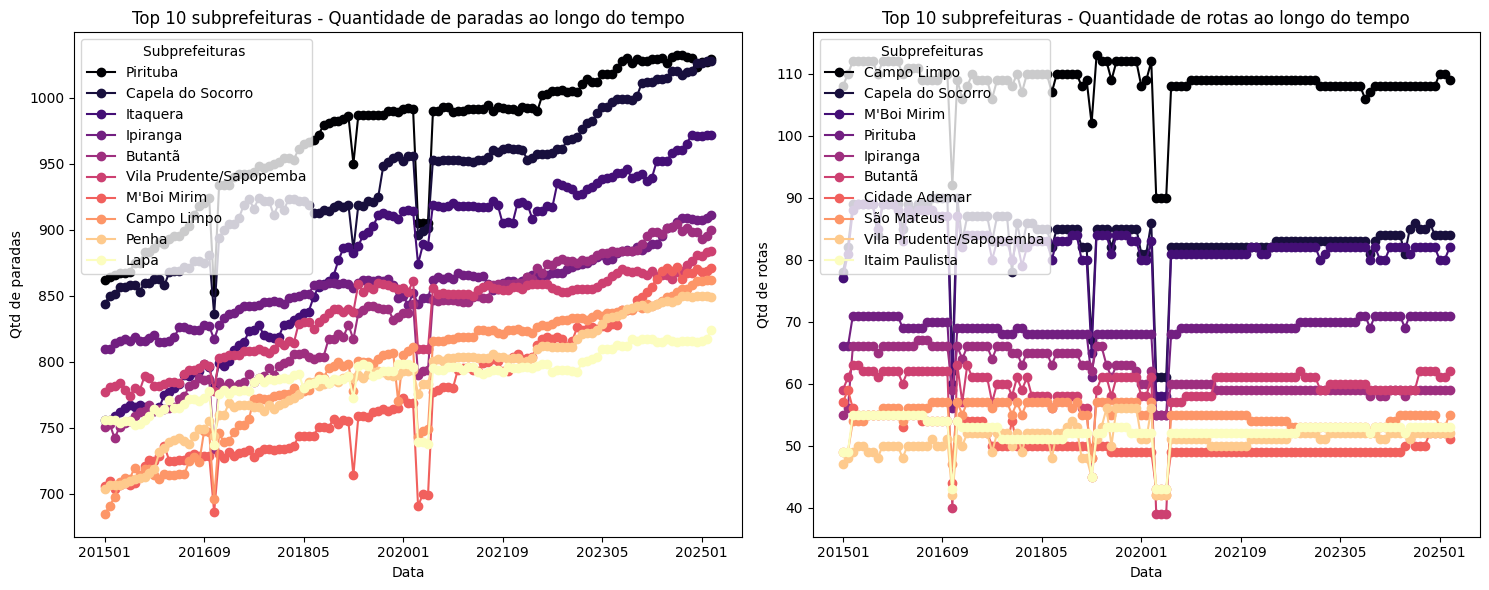

In [57]:
qtd_paradas_por_zona_historico=df_trips.drop_duplicates(subset=['data_referencia','stop_id']).groupby(["data_referencia",'Subprefeituras ']).count()['stop_id'].unstack()
qtd_rotas_por_zona_historico=df_trips.drop_duplicates(subset=['data_referencia','route_id']).groupby(["data_referencia",'Subprefeituras ']).count()['route_id'].unstack()

# pegar top 10 distritos pela soma total
top10_paradas = qtd_paradas_por_zona_historico.max().nlargest(10).index
top10_rotas   = qtd_rotas_por_zona_historico.max().nlargest(10).index

# filtrar apenas os top 10
qtd_paradas_top10 = qtd_paradas_por_zona_historico[top10_paradas]
qtd_rotas_top10   = qtd_rotas_por_zona_historico[top10_rotas]

# plotar
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

qtd_paradas_top10.plot(marker="o", ax=axes[0],colormap='magma')
axes[0].set_title("Top 10 subprefeituras - Quantidade de paradas ao longo do tempo")
axes[0].set_ylabel("Qtd de paradas")
axes[0].set_xlabel("Data")

qtd_rotas_top10.plot(marker="o", ax=axes[1],colormap='magma')
axes[1].set_title("Top 10 subprefeituras - Quantidade de rotas ao longo do tempo")
axes[1].set_ylabel("Qtd de rotas")
axes[1].set_xlabel("Data")

plt.tight_layout()
plt.show()

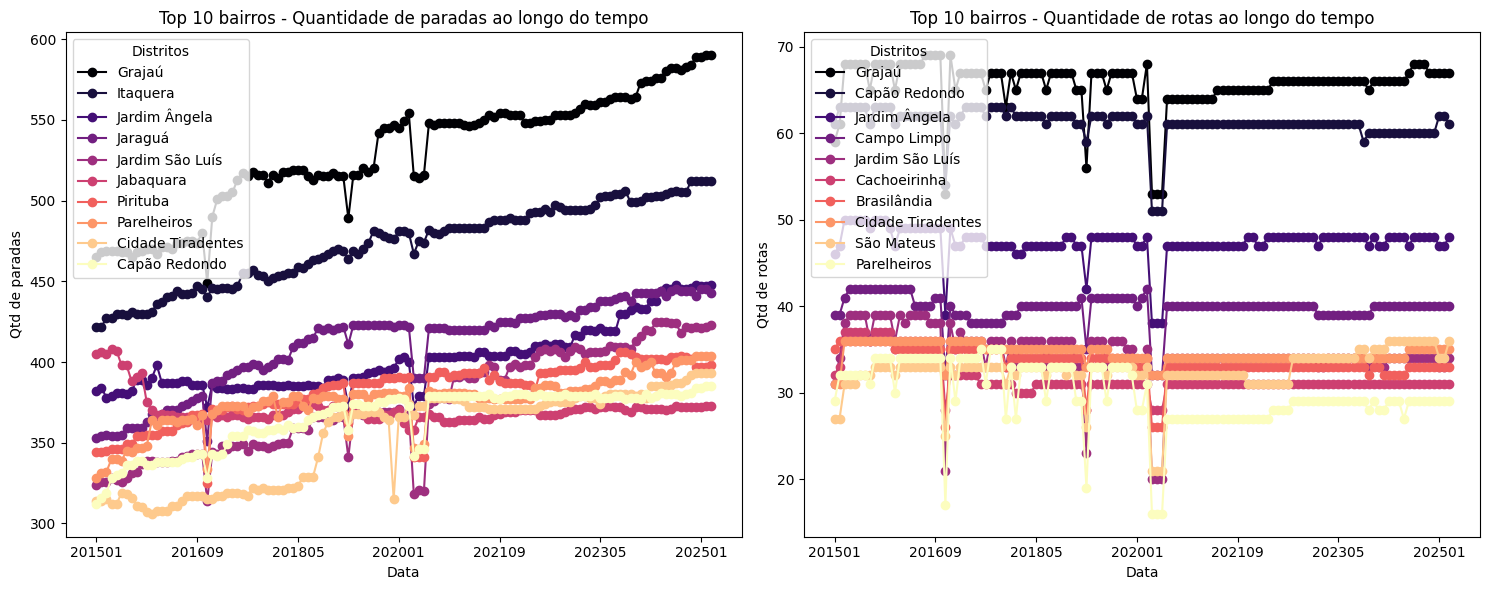

In [58]:
qtd_paradas_por_zona_historico=df_trips.drop_duplicates(subset=['data_referencia','stop_id']).groupby(["data_referencia",'Distritos']).count()['stop_id'].unstack()
qtd_rotas_por_zona_historico=df_trips.drop_duplicates(subset=['data_referencia','route_id']).groupby(["data_referencia",'Distritos']).count()['route_id'].unstack()

# pegar top 10 distritos pela soma total
top10_paradas = qtd_paradas_por_zona_historico.max().nlargest(10).index
top10_rotas   = qtd_rotas_por_zona_historico.max().nlargest(10).index

# filtrar apenas os top 10
qtd_paradas_top10 = qtd_paradas_por_zona_historico[top10_paradas]
qtd_rotas_top10   = qtd_rotas_por_zona_historico[top10_rotas]

# plotar
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

qtd_paradas_top10.plot(marker="o", ax=axes[0],colormap='magma')
axes[0].set_title("Top 10 bairros - Quantidade de paradas ao longo do tempo")
axes[0].set_ylabel("Qtd de paradas")
axes[0].set_xlabel("Data")

qtd_rotas_top10.plot(marker="o", ax=axes[1],colormap='magma')
axes[1].set_title("Top 10 bairros - Quantidade de rotas ao longo do tempo")
axes[1].set_ylabel("Qtd de rotas")
axes[1].set_xlabel("Data")

plt.tight_layout()
plt.show()

In [60]:
qtd_paradas_por_zona_historico=df_trips.rename(columns={"nome_estacao_mais_proxima_existente":"Estação mais próxima existente"}).drop_duplicates(subset=['data_referencia','stop_id']).groupby(["data_referencia",'Estação mais próxima existente']).count()['stop_id'].unstack()
qtd_rotas_por_zona_historico=df_trips.drop_duplicates(subset=['data_referencia','route_id']).groupby(["data_referencia",'Estação mais próxima existente']).count()['route_id'].unstack()

# pegar top 10 distritos pela soma total
top10_paradas = qtd_paradas_por_zona_historico.max().nlargest(10).index
top10_rotas   = qtd_rotas_por_zona_historico.max().nlargest(10).index

# filtrar apenas os top 10
qtd_paradas_top10 = qtd_paradas_por_zona_historico[top10_paradas]
qtd_rotas_top10   = qtd_rotas_por_zona_historico[top10_rotas]

# plotar
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

qtd_paradas_top10.plot(marker="o", ax=axes[0],colormap='magma')
axes[0].set_title("Top 10 estações atuais com mais paradas próximas ao longo do tempo")
axes[0].set_ylabel("Qtd de paradas")
axes[0].set_xlabel("Data")

qtd_rotas_top10.plot(marker="o", ax=axes[1],colormap='magma')
axes[1].set_title("Top 10 estações atuais com mais rotas próximas ao longo do tempo")
axes[1].set_ylabel("Qtd de rotas")
axes[1].set_xlabel("Data")

plt.tight_layout()
plt.show()

KeyError: 'Estação mais próxima existente'

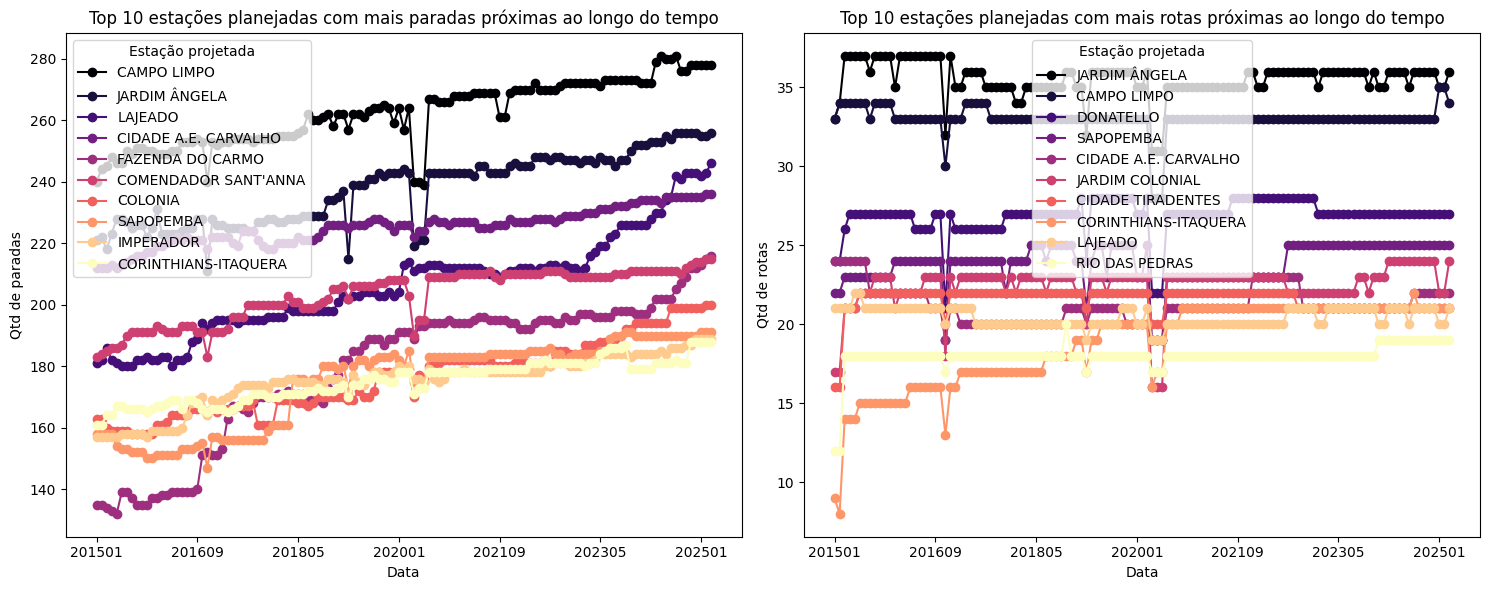

In [62]:
qtd_paradas_por_zona_historico=df_trips.rename(columns={"nome_estacao_mais_proxima_projetado":"Estação projetada"}).drop_duplicates(subset=['data_referencia','stop_id']).groupby(["data_referencia",'Estação projetada']).count()['stop_id'].unstack()
qtd_rotas_por_zona_historico=df_trips.rename(columns={"nome_estacao_mais_proxima_projetado":"Estação projetada"}).drop_duplicates(subset=['data_referencia','route_id']).groupby(["data_referencia",'Estação projetada']).count()['route_id'].unstack()

# pegar top 10 distritos pela soma total
top10_paradas = qtd_paradas_por_zona_historico.max().nlargest(10).index
top10_rotas   = qtd_rotas_por_zona_historico.max().nlargest(10).index

# filtrar apenas os top 10
qtd_paradas_top10 = qtd_paradas_por_zona_historico[top10_paradas]
qtd_rotas_top10   = qtd_rotas_por_zona_historico[top10_rotas]

# plotar
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

qtd_paradas_top10.plot(marker="o", ax=axes[0],colormap='magma')
axes[0].set_title("Top 10 estações planejadas com mais paradas próximas ao longo do tempo")
axes[0].set_ylabel("Qtd de paradas")
axes[0].set_xlabel("Data")

qtd_rotas_top10.plot(marker="o", ax=axes[1],colormap='magma')
axes[1].set_title("Top 10 estações planejadas com mais rotas próximas ao longo do tempo")
axes[1].set_ylabel("Qtd de rotas")
axes[1].set_xlabel("Data")

plt.tight_layout()
plt.show()

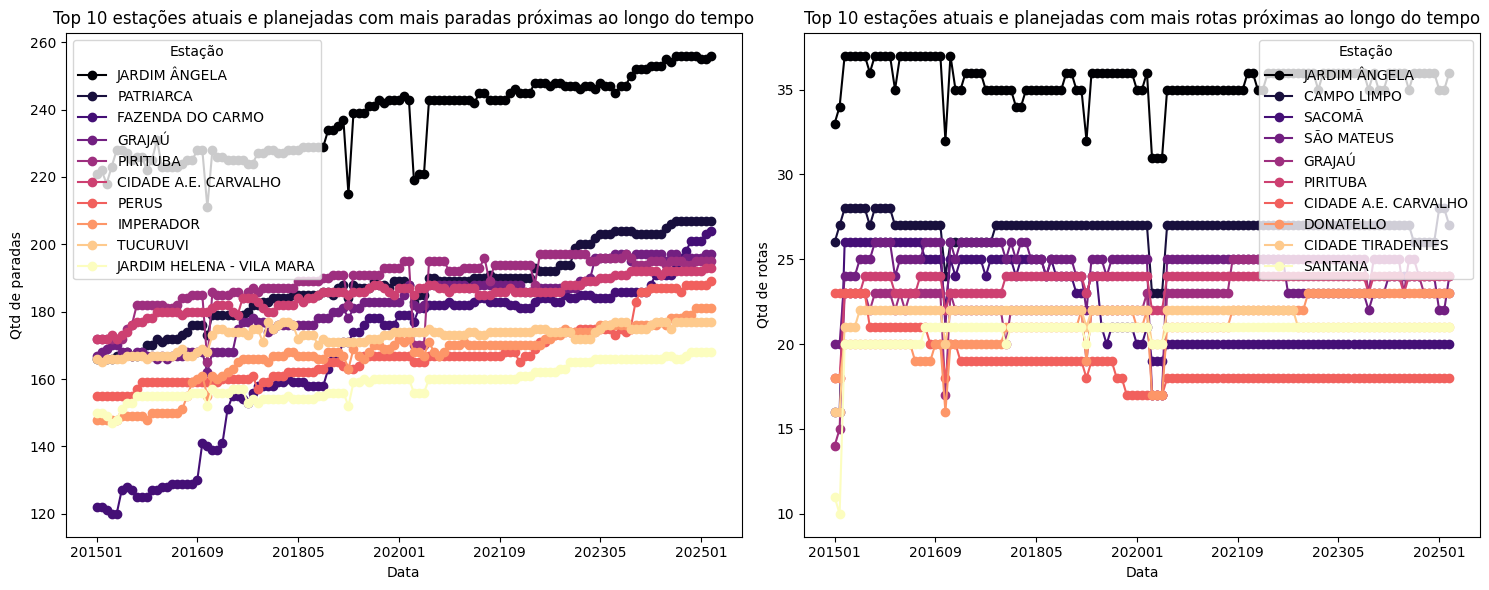

In [64]:
qtd_paradas_por_zona_historico=df_trips.rename(columns={"nome_estacao_mais_proxima":"Estação"}).drop_duplicates(subset=['data_referencia','stop_id']).groupby(["data_referencia",'Estação']).count()['stop_id'].unstack()
qtd_rotas_por_zona_historico=df_trips.rename(columns={"nome_estacao_mais_proxima":"Estação"}).drop_duplicates(subset=['data_referencia','route_id']).groupby(["data_referencia",'Estação']).count()['route_id'].unstack()

# pegar top 10 distritos pela soma total
top10_paradas = qtd_paradas_por_zona_historico.max().nlargest(10).index
top10_rotas   = qtd_rotas_por_zona_historico.max().nlargest(10).index

# filtrar apenas os top 10
qtd_paradas_top10 = qtd_paradas_por_zona_historico[top10_paradas]
qtd_rotas_top10   = qtd_rotas_por_zona_historico[top10_rotas]

# plotar
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

qtd_paradas_top10.plot(marker="o", ax=axes[0],colormap='magma')
axes[0].set_title("Top 10 estações atuais e planejadas com mais paradas próximas ao longo do tempo")
axes[0].set_ylabel("Qtd de paradas")
axes[0].set_xlabel("Data")

qtd_rotas_top10.plot(marker="o", ax=axes[1],colormap='magma')
axes[1].set_title("Top 10 estações atuais e planejadas com mais rotas próximas ao longo do tempo")
axes[1].set_ylabel("Qtd de rotas")
axes[1].set_xlabel("Data")

plt.tight_layout()
plt.show()

# Correlações com a população

In [82]:
df_unico_setor = df_trips.drop_duplicates(subset=['data_referencia', 'CD_SETOR'])
soma_v0001_unico_setor = df_unico_setor.groupby('data_referencia')['v0001'].sum()

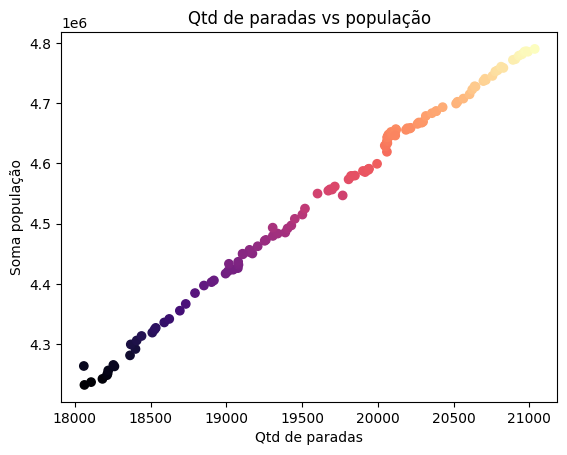

In [91]:
# considerando a população próxima de paradas, podemos ver que as novas paradas que estão surgindo estão em locais novos, 
# dado que a quantidade de população aumenta linearmente conforme o aumento de quantidade de paradas

qtd_paradas_historico = (
    df_trips.drop_duplicates(subset=['data_referencia','stop_id'])
    .groupby('data_referencia')['stop_id']
    .count()
)

# juntar em um DataFrame
df_historico = pd.concat([qtd_paradas_historico, soma_v0001_unico_setor], axis=1)
df_historico.columns = ['qtd_paradas', 'soma_v0001']

plt.scatter(df_historico['qtd_paradas'], df_historico['soma_v0001'],c=df_historico['soma_v0001'],  # values that determine the color
    cmap='magma')
# plt.colorbar(label='soma_v0001')   # optional colorbar

plt.xlabel("Qtd de paradas")
plt.ylabel("Soma população")
plt.title("Qtd de paradas vs população")
plt.show()

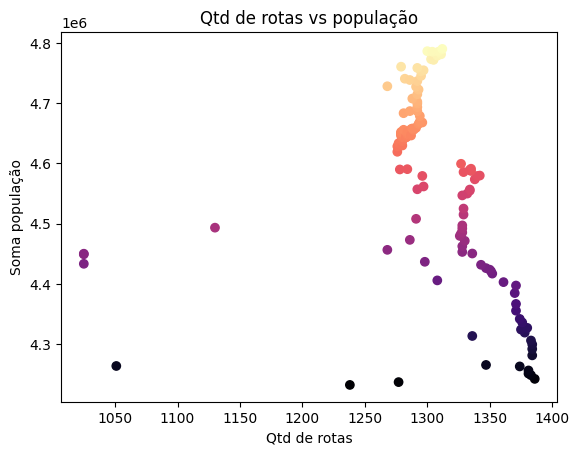

In [92]:
# não há relação clara entre a qtd de rotas e a população
qtd_paradas_historico = (
    df_trips.drop_duplicates(subset=['data_referencia','route_id'])
    .groupby('data_referencia')['route_id']
    .count()
)

# juntar em um DataFrame
df_historico = pd.concat([qtd_paradas_historico, soma_v0001_unico_setor], axis=1)
df_historico.columns = ['qtd_rotas', 'soma_v0001']

plt.scatter(df_historico['qtd_rotas'], df_historico['soma_v0001'],c=df_historico['soma_v0001'],  # values that determine the color
    cmap='magma')
plt.xlabel("Qtd de rotas")
plt.ylabel("Soma população")
plt.title("Qtd de rotas vs população")
plt.show()

# Novas rotas e paradas

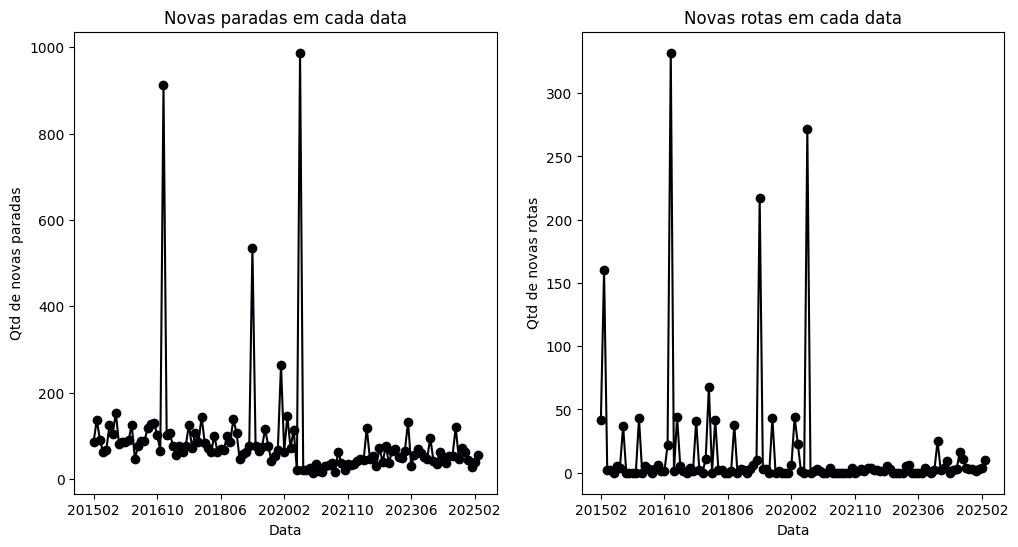

In [65]:
df_trips = df_trips.sort_values('data_referencia')

# criar dataframe com stop_id únicos por data
stops_por_data = df_trips.drop_duplicates(subset=['data_referencia','stop_id']) \
                         .groupby('data_referencia')['stop_id'].apply(set)

# função para contar novos stops
novos_stops = {}
previous_set = set()

for data, stops_set in stops_por_data.items():
    # elementos que estão na data atual mas não na anterior
    novos = stops_set - previous_set
    novos_stops[data] = len(novos)
    previous_set = stops_set

# transformar em série pandas
novos_stops_series = pd.Series(novos_stops)
novos_stops_series=novos_stops_series[novos_stops_series.index != novos_stops_series.index.min()]

# criar dataframe com stop_id únicos por data
rotas_por_data = df_trips.drop_duplicates(subset=['data_referencia','route_id']) \
                         .groupby('data_referencia')['route_id'].apply(set)

# função para contar novos stops
novos_rotas = {}
previous_set = set()

for data, rotas_set in rotas_por_data.items():
    # elementos que estão na data atual mas não na anterior
    novos = rotas_set - previous_set
    novos_rotas[data] = len(novos)
    previous_set = rotas_set

# transformar em série pandas
novos_rotas_series = pd.Series(novos_rotas)
novos_rotas_series=novos_rotas_series[novos_rotas_series.index != novos_rotas_series.index.min()]


fig, axes = plt.subplots(1, 2, figsize=(15, 4))


novos_stops_series.plot(marker='o', figsize=(12,6),ax=axes[0],colormap='magma')
axes[0].set_title("Novas paradas em cada data")
axes[0].set_ylabel("Qtd de novas paradas")
axes[0].set_xlabel("Data")

novos_rotas_series.plot(marker='o', figsize=(12,6),ax=axes[1],colormap='magma')
axes[1].set_title("Novas rotas em cada data")
axes[1].set_ylabel("Qtd de novas rotas")
axes[1].set_xlabel("Data")


plt.show()

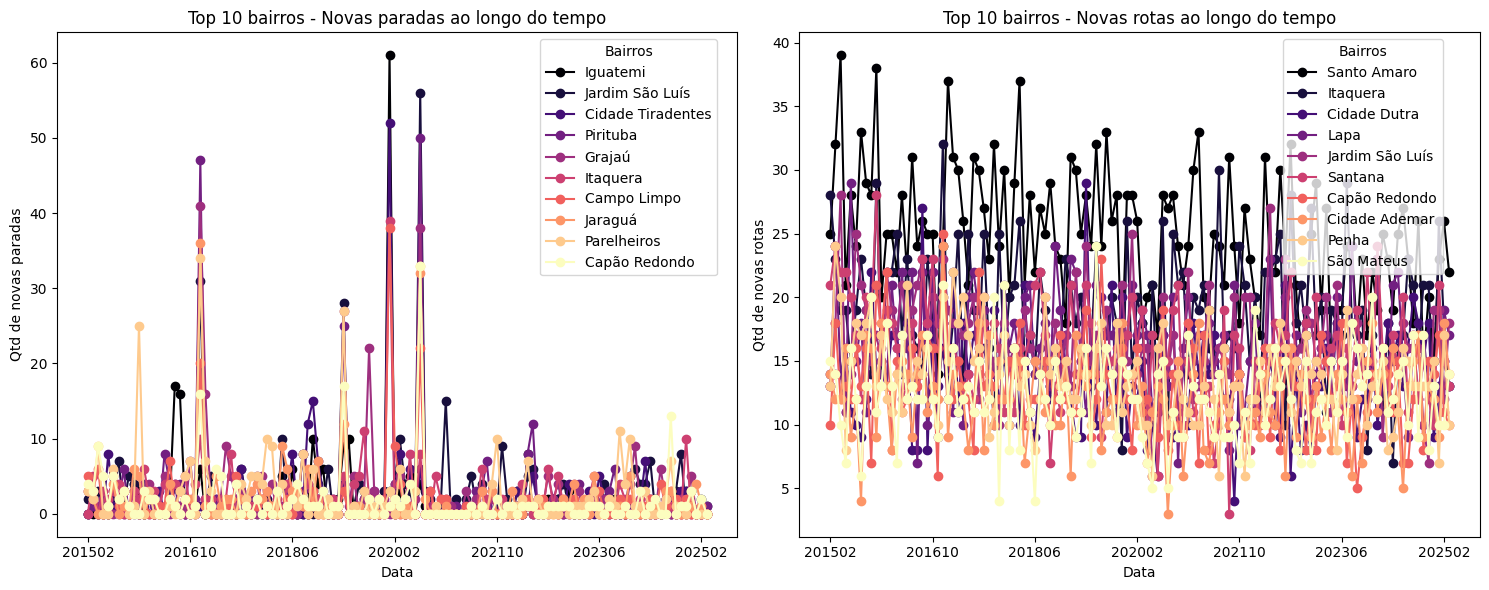

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

df_trips = df_trips.sort_values('data_referencia')
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# criar sets de stop_id únicos por data e distrito
stops_por_data_distrito = (
    df_trips.drop_duplicates(subset=['data_referencia','stop_id'])
    .groupby(['data_referencia', 'Distritos'])['stop_id']
    .apply(set)
    .unstack(fill_value=set())  # cada coluna = distrito, cada célula = set de stops
)

# calcular novos stops por distrito
novos_stops_distrito = pd.DataFrame(index=stops_por_data_distrito.index, columns=stops_por_data_distrito.columns)
previous_sets = {distrito: set() for distrito in stops_por_data_distrito.columns}

for data in stops_por_data_distrito.index:
    for distrito in stops_por_data_distrito.columns:
        current_set = stops_por_data_distrito.loc[data, distrito]
        novos = current_set - previous_sets[distrito]
        novos_stops_distrito.loc[data, distrito] = len(novos)
        previous_sets[distrito] = current_set

# converter para números inteiros
novos_stops_distrito = novos_stops_distrito.astype(int)

# remover a primeira data
novos_stops_distrito = novos_stops_distrito.iloc[1:]

# selecionar os top 10 distritos pelo máximo de novos stops
top10_distritos = novos_stops_distrito.max().nlargest(10).index
novos_stops_top10 = novos_stops_distrito[top10_distritos]

# plotar
novos_stops_top10.plot(marker='o', figsize=(15,6),ax=axes[0],colormap='magma')
axes[0].set_title("Top 10 bairros - Novas paradas ao longo do tempo")
axes[0].set_ylabel("Qtd de novas paradas")
axes[0].set_xlabel("Data")
axes[0].legend(title="Bairros", bbox_to_anchor=(0.7, 1), loc='upper left')


# criar sets de route_id únicos por data e distrito
routes_por_data_distrito = (
    df_trips.drop_duplicates(subset=['data_referencia','route_id'])
    .groupby(['data_referencia', 'Distritos'])['route_id']
    .apply(set)
    .unstack(fill_value=set())  # cada coluna = distrito, cada célula = set de routes
)

# calcular novos routes por distrito
novos_routes_distrito = pd.DataFrame(index=routes_por_data_distrito.index, columns=routes_por_data_distrito.columns)
previous_sets = {distrito: set() for distrito in routes_por_data_distrito.columns}

for data in routes_por_data_distrito.index:
    for distrito in routes_por_data_distrito.columns:
        current_set = routes_por_data_distrito.loc[data, distrito]
        novos = current_set - previous_sets[distrito]
        novos_routes_distrito.loc[data, distrito] = len(novos)
        previous_sets[distrito] = current_set

# converter para números inteiros
novos_routes_distrito = novos_routes_distrito.astype(int)

# remover a primeira data
novos_routes_distrito = novos_routes_distrito.iloc[1:]

# selecionar os top 10 distritos pelo máximo de novos routes
top10_distritos = novos_routes_distrito.max().nlargest(10).index
novos_routes_top10 = novos_routes_distrito[top10_distritos]

# plotar
novos_routes_top10.plot(marker='o', figsize=(15,6),ax=axes[1],colormap='magma')
axes[1].set_title("Top 10 bairros - Novas rotas ao longo do tempo")
axes[1].set_ylabel("Qtd de novas rotas")
axes[1].set_xlabel("Data")
axes[1].legend(title="Bairros", bbox_to_anchor=(0.7, 1), loc='upper left')

plt.tight_layout()

plt.tight_layout()
plt.show()

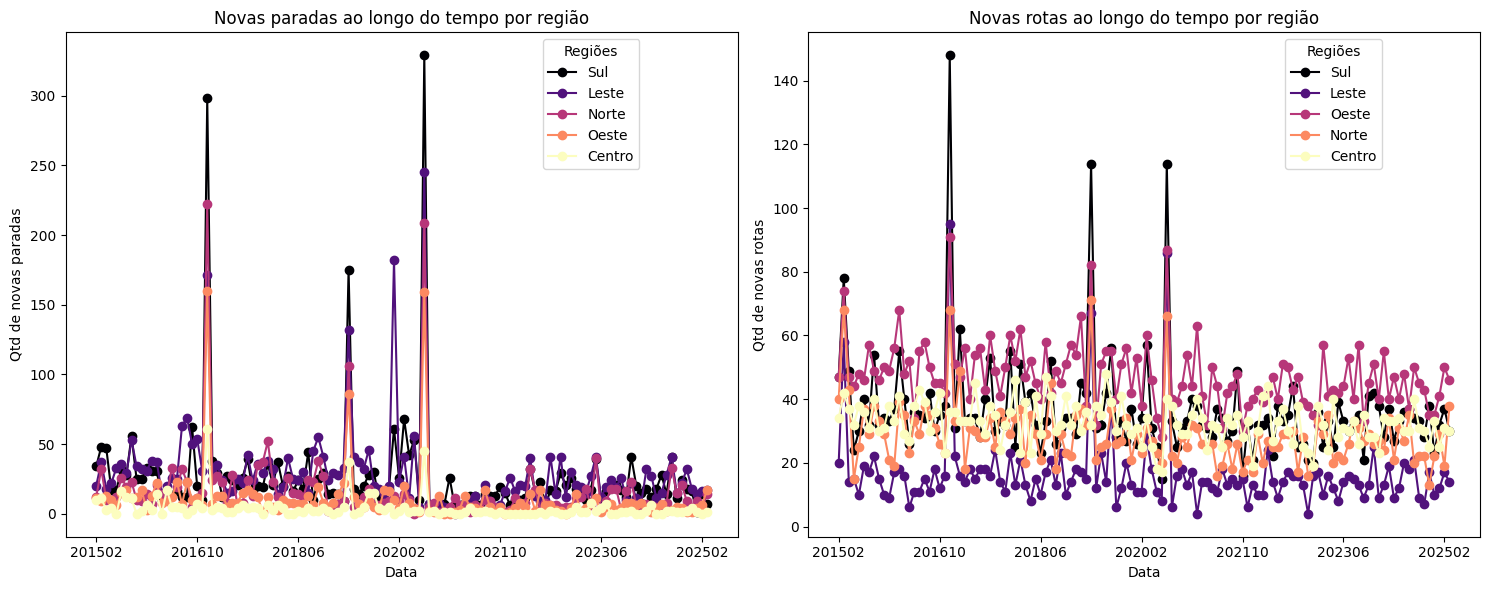

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# criar sets de stop_id únicos por data e distrito
stops_por_data_distrito = (
    df_trips.drop_duplicates(subset=['data_referencia','stop_id'])
    .groupby(['data_referencia', 'Regiões'])['stop_id']
    .apply(set)
    .unstack(fill_value=set())  # cada coluna = distrito, cada célula = set de stops
)

# calcular novos stops por distrito
novos_stops_distrito = pd.DataFrame(index=stops_por_data_distrito.index, columns=stops_por_data_distrito.columns)
previous_sets = {distrito: set() for distrito in stops_por_data_distrito.columns}

for data in stops_por_data_distrito.index:
    for distrito in stops_por_data_distrito.columns:
        current_set = stops_por_data_distrito.loc[data, distrito]
        novos = current_set - previous_sets[distrito]
        novos_stops_distrito.loc[data, distrito] = len(novos)
        previous_sets[distrito] = current_set

# converter para números inteiros
novos_stops_distrito = novos_stops_distrito.astype(int)

# remover a primeira data
novos_stops_distrito = novos_stops_distrito.iloc[1:]

# selecionar os top 10 distritos pelo máximo de novos stops
top10_distritos = novos_stops_distrito.max().nlargest(10).index
novos_stops_top10 = novos_stops_distrito[top10_distritos]

# plotar
novos_stops_top10.plot(marker='o', figsize=(15,6),ax=axes[0],colormap='magma')
axes[0].set_title("Novas paradas ao longo do tempo por região")
axes[0].set_ylabel("Qtd de novas paradas")
axes[0].set_xlabel("Data")
axes[0].legend(title="Regiões", bbox_to_anchor=(0.7, 1), loc='upper left')


# criar sets de route_id únicos por data e distrito
routes_por_data_distrito = (
    df_trips.drop_duplicates(subset=['data_referencia','route_id'])
    .groupby(['data_referencia', 'Regiões'])['route_id']
    .apply(set)
    .unstack(fill_value=set())  # cada coluna = distrito, cada célula = set de routes
)

# calcular novos routes por distrito
novos_routes_distrito = pd.DataFrame(index=routes_por_data_distrito.index, columns=routes_por_data_distrito.columns)
previous_sets = {distrito: set() for distrito in routes_por_data_distrito.columns}

for data in routes_por_data_distrito.index:
    for distrito in routes_por_data_distrito.columns:
        current_set = routes_por_data_distrito.loc[data, distrito]
        novos = current_set - previous_sets[distrito]
        novos_routes_distrito.loc[data, distrito] = len(novos)
        previous_sets[distrito] = current_set

# converter para números inteiros
novos_routes_distrito = novos_routes_distrito.astype(int)

# remover a primeira data
novos_routes_distrito = novos_routes_distrito.iloc[1:]

# selecionar os top 10 distritos pelo máximo de novos routes
top10_distritos = novos_routes_distrito.max().nlargest(10).index
novos_routes_top10 = novos_routes_distrito[top10_distritos]

# plotar
novos_routes_top10.plot(marker='o', figsize=(15,6),ax=axes[1],colormap='magma')
axes[1].set_title("Novas rotas ao longo do tempo por região")
axes[1].set_ylabel("Qtd de novas rotas")
axes[1].set_xlabel("Data")
axes[1].legend(title="Regiões", bbox_to_anchor=(0.7, 1), loc='upper left')

plt.tight_layout()
plt.show()

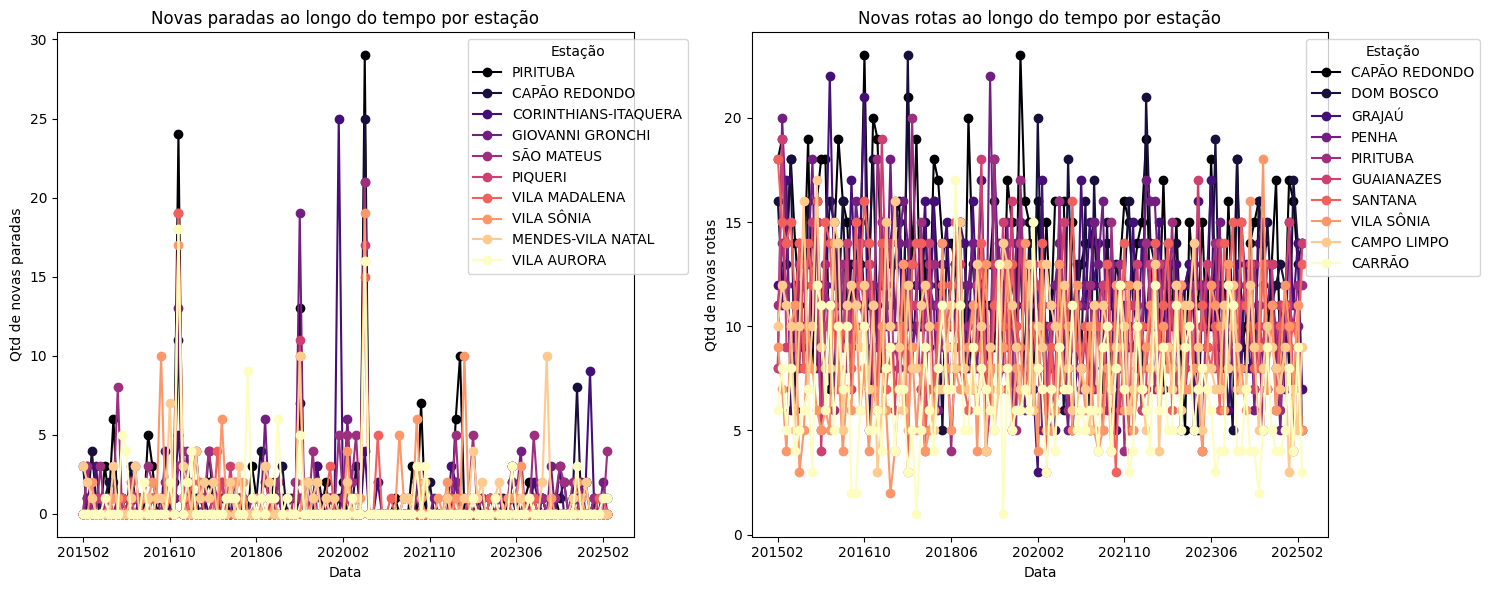

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# criar sets de stop_id únicos por data e distrito
stops_por_data_distrito = (
    df_trips.drop_duplicates(subset=['data_referencia','stop_id'])
    .groupby(['data_referencia', 'nome_estacao_mais_proxima_existente'])['stop_id']
    .apply(set)
    .unstack(fill_value=set())  # cada coluna = distrito, cada célula = set de stops
)

# calcular novos stops por distrito
novos_stops_distrito = pd.DataFrame(index=stops_por_data_distrito.index, columns=stops_por_data_distrito.columns)
previous_sets = {distrito: set() for distrito in stops_por_data_distrito.columns}

for data in stops_por_data_distrito.index:
    for distrito in stops_por_data_distrito.columns:
        current_set = stops_por_data_distrito.loc[data, distrito]
        novos = current_set - previous_sets[distrito]
        novos_stops_distrito.loc[data, distrito] = len(novos)
        previous_sets[distrito] = current_set

# converter para números inteiros
novos_stops_distrito = novos_stops_distrito.astype(int)

# remover a primeira data
novos_stops_distrito = novos_stops_distrito.iloc[1:]

# selecionar os top 10 distritos pelo máximo de novos stops
top10_distritos = novos_stops_distrito.max().nlargest(10).index
novos_stops_top10 = novos_stops_distrito[top10_distritos]

# plotar
novos_stops_top10.plot(marker='o', figsize=(15,6),ax=axes[0],colormap='magma')
axes[0].set_title("Novas paradas ao longo do tempo por estação")
axes[0].set_ylabel("Qtd de novas paradas")
axes[0].set_xlabel("Data")
axes[0].legend(title="Estação", bbox_to_anchor=(0.7, 1), loc='upper left')


# criar sets de route_id únicos por data e distrito
routes_por_data_distrito = (
    df_trips.drop_duplicates(subset=['data_referencia','route_id'])
    .groupby(['data_referencia', 'nome_estacao_mais_proxima_existente'])['route_id']
    .apply(set)
    .unstack(fill_value=set())  # cada coluna = distrito, cada célula = set de routes
)

# calcular novos routes por distrito
novos_routes_distrito = pd.DataFrame(index=routes_por_data_distrito.index, columns=routes_por_data_distrito.columns)
previous_sets = {distrito: set() for distrito in routes_por_data_distrito.columns}

for data in routes_por_data_distrito.index:
    for distrito in routes_por_data_distrito.columns:
        current_set = routes_por_data_distrito.loc[data, distrito]
        novos = current_set - previous_sets[distrito]
        novos_routes_distrito.loc[data, distrito] = len(novos)
        previous_sets[distrito] = current_set

# converter para números inteiros
novos_routes_distrito = novos_routes_distrito.astype(int)

# remover a primeira data
novos_routes_distrito = novos_routes_distrito.iloc[1:]

# selecionar os top 10 distritos pelo máximo de novos routes
top10_distritos = novos_routes_distrito.max().nlargest(10).index
novos_routes_top10 = novos_routes_distrito[top10_distritos]

# plotar
novos_routes_top10.plot(marker='o', figsize=(15,6),ax=axes[1],colormap='magma')
plt.title("Novas rotas ao longo do tempo por estação")
plt.ylabel("Qtd de novas rotas")
plt.xlabel("Data")
plt.legend(title="Estação", bbox_to_anchor=(0.95, 1), loc='upper left')
plt.tight_layout()

plt.tight_layout()
plt.show()

# Passageiros

In [4]:
import scipy.stats as stats


In [5]:
df_passageiros.columns

Index(['data', 'tipo', 'area', 'empresa', 'linha', 'passageiros_dinheiro',
       'passageiros_comum', 'passageiros_comum_mensal',
       'passageiros_estudante', 'passageiros_estudante_mensal',
       'passageiros_comum_vt', 'passageiros_vale_transporte_mensal',
       'passageiros_integracao_metro_cptm',
       'passageiros_integracao_metro_cptm_mensal', 'passageiros_pagantes',
       'passageiros_integracao_onibus', 'passageiros_gratuitos',
       'passageiros_gratuitos_estudante', 'passageiros_total', 'arquivo',
       'grupo', 'lote', 'passageiros_vale_transporte', 'route_id',
       'passageiros_integracao'],
      dtype='object')

In [12]:
df_filtrado=df_passageiros[df_passageiros.data<'2020-01-01']

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


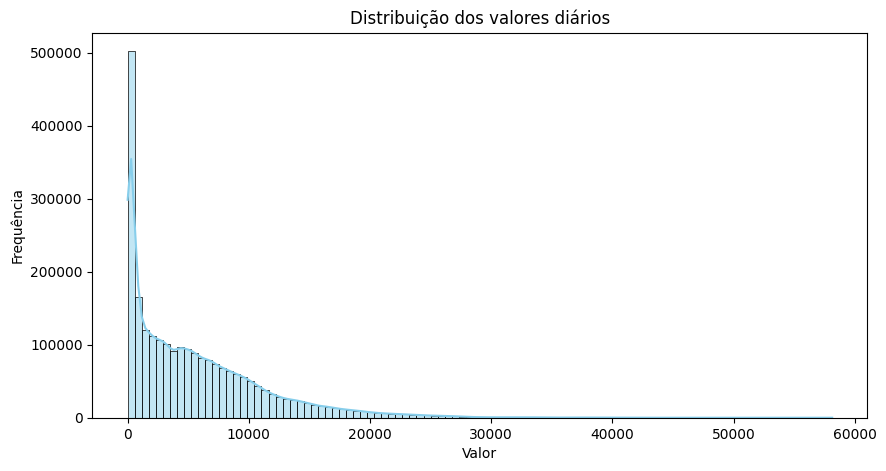

In [13]:
coluna = 'passageiros_total'  # substitua pelo nome real da sua coluna

plt.figure(figsize=(10,5))

# Histograma com curva de densidade
sns.histplot(df_filtrado[coluna], kde=True, bins=100, color='skyblue')
plt.title('Distribuição dos valores diários')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()